In [17]:
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing import Annotated,Sequence
from langchain_openai import ChatOpenAI

In [18]:
llm = ChatOpenAI(model='gpt-4o-mini',temperature=0)

In [19]:
search_tool = TavilySearchResults(max_results=5)
tools = [search_tool]
tool_node = ToolNode(tools)


In [20]:
llm = llm.bind_tools(tools)

In [21]:
"""
from typing import TypedDict
class ReportState(TypedDict):
    business_owner_manager_report:str
    marketing_report:str
    real_estate_report:str
    investor_report:str
"""

'\nfrom typing import TypedDict\nclass ReportState(TypedDict):\n    business_owner_manager_report:str\n    marketing_report:str\n    real_estate_report:str\n    investor_report:str\n'

In [22]:
def call_business_owner_manager_analyst(state: MessagesState):
    messages = state['messages']
    system_prompt = """You are an expert in identifying key competitors and analyzing and suggesting strategies to improve market position."""
    
    response = llm.invoke([
        {"role": "system", "content": system_prompt},
        *messages
    ])
    return {'messages': messages + [response]}

def call_marketing_analyst(state: MessagesState):
    messages = state['messages']
    system_prompt = """You are an expert in suggesting footfall trends and targeted marketing strategy campaigns."""
    
    response = llm.invoke([
        {"role": "system", "content": system_prompt},
        *messages
    ])
    print(response)
    return {'messages': messages + [response]}

def call_real_estate_analyst(state: MessagesState):
    messages = state['messages']
    system_prompt = """You are an expert in recommending ideal store locations and identifying high volume times for new store locations."""
    
    response = llm.invoke([
        {"role": "system", "content": system_prompt},
        *messages
    ])
    return {'messages': messages + [response]}

def call_investor_analyst(state: MessagesState):
    messages = state['messages']
    system_prompt = """You are an expert in assessing market saturation, business potential, and potential risks in high-traffic areas like Koramangala, Bangalore."""
    
    response = llm.invoke([
        {"role": "system", "content": system_prompt},
        *messages
    ])
    return {'messages': messages + [response]}

def call_report_summarizer(state: MessagesState):
    messages = state['messages']
    system_prompt = """You are an expert in making a report summary from the reports provided by the analysts."""
    model = ChatOpenAI(model='gpt-4o-mini',temperature=0)
    response = model.invoke([
        {"role": "system", "content": system_prompt},
        *messages
    ])
    return {'messages': response}

In [23]:
def call_planner(state: MessagesState):
    messages = state['messages']
    system_prompt = """You are a planning agent that determines which expert analyst should look at this problem next.
    Choose from the following options:
    - 'business': For competitor analysis and market position strategies
    - 'marketing': For footfall trends and marketing campaigns
    - 'real_estate': For store location recommendations
    - 'investor': For market saturation and risk assessment
    - 'end': If all necessary analysis is complete
    
    Respond with just one word from the options above."""
    model = ChatOpenAI(model='gpt-4o-mini',temperature=0)
    response = model.invoke([
        {"role": "system", "content": system_prompt},
        *messages
    ])
    return {'messages': messages + [response]}

In [24]:
def router(state: MessagesState) -> str:
    messages = state['messages']
    last_message = messages[-1].content.strip().lower()
    
    match last_message:
        case 'business':
            return 'business_analyst'
        case 'marketing':
            return 'marketing_analyst'
        case 'real_estate':
            return 'real_estate_analyst'
        case 'investor':
            return 'investor_analyst'
        case 'end':
            return END

In [25]:
# Update the graph
graph = StateGraph(MessagesState)

# Add all nodes
graph.add_node('planner', call_planner)
graph.add_node('search',tool_node)
graph.add_node('business_analyst', call_business_owner_manager_analyst)
graph.add_node('marketing_analyst', call_marketing_analyst)
graph.add_node('real_estate_analyst', call_real_estate_analyst)
graph.add_node('investor_analyst', call_investor_analyst)
graph.add_node('report_summarizer', call_report_summarizer)
# Add edges
graph.add_conditional_edges('planner', router)

graph.add_conditional_edges('business_analyst',tools_condition,{'tools':'search',END:END})
graph.add_edge('search','business_analyst')

graph.add_conditional_edges('marketing_analyst',tools_condition,{'tools':'search',END:END})
graph.add_edge('search','marketing_analyst')

graph.add_conditional_edges('real_estate_analyst',tools_condition,{'tools':'search',END:END})
graph.add_edge('search','real_estate_analyst')

graph.add_conditional_edges('investor_analyst',tools_condition,{'tools':'search',END:END})
graph.add_edge('search','investor_analyst')

graph.add_edge('business_analyst', 'report_summarizer')
graph.add_edge('marketing_analyst', 'report_summarizer')
graph.add_edge('real_estate_analyst', 'report_summarizer')
graph.add_edge('investor_analyst', 'report_summarizer')
graph.add_edge('report_summarizer', END)


graph.add_edge(START,'planner')

compiled_graph = graph.compile()

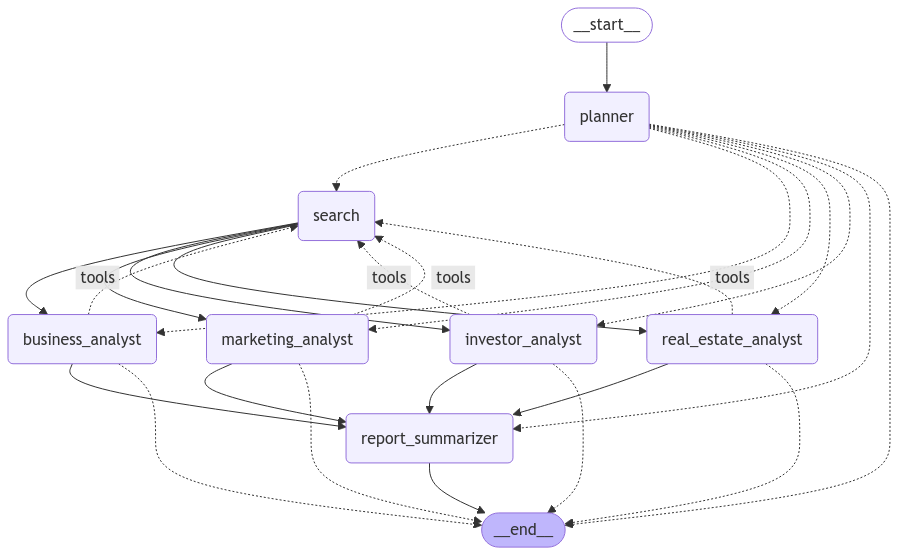

In [26]:
from IPython.display import Image

Image(compiled_graph.get_graph().draw_mermaid_png())

In [27]:
import pprint

inputs ={"messages":[("user","How to increase footfall in Koramangala?")]}

In [28]:
for output in compiled_graph.stream(inputs):
    for key,value in output.items():
        pprint.pprint(f"output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value , indent = 2 , width =80 , depth =None)
    pprint.pprint("\n---\n")

"output from node 'planner':"
'---'
{ 'messages': [ HumanMessage(content='How to increase footfall in Koramangala?', additional_kwargs={}, response_metadata={}, id='e30d167e-4dbc-4ab9-ac6f-4e86f2816565'),
                AIMessage(content='marketing', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 119, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_6fc10e10eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-353c22ad-f7c0-4fdc-900e-8c4a1b86dbbb-0', usage_metadata={'input_tokens': 119, 'output_tokens': 1, 'total_tokens': 120, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
'\n---\n'
content='' additional_kwargs={'t

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_ufFsjqMAZDhn5edsH8pgBTIW", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}